In [15]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
print(tf.__version__)

1.9.0


In [5]:
# Load the data
used_features = ['property_type','room_type','bathrooms','bedrooms','beds','bed_type','accommodates','host_total_listings_count',
                 'number_of_reviews','review_scores_value','neighbourhood_cleansed','cleaning_fee','minimum_nights','security_deposit',
                 'host_is_superhost', 'instant_bookable', 'price']

df = pd.read_csv('data/listings.csv', usecols=used_features)
print(df.shape)
df.head()

(3585, 17)


,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews,review_scores_value,instant_bookable
0,f,1,Roslindale,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,$250.00,NaN,$35.00,2,0,NaN,f
1,f,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,$65.00,$95.00,$10.00,2,36,9.0,t
2,t,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,$65.00,NaN,NaN,3,41,10.0,f
3,f,1,Roslindale,House,Private room,4,1.0,1.0,2.0,Real Bed,$75.00,$100.00,$50.00,1,1,10.0,f
4,t,1,Roslindale,House,Private room,2,1.5,1.0,2.0,Real Bed,$79.00,NaN,$15.00,2,29,10.0,f


In [7]:
# Data preprocessing
for feature in ["cleaning_fee", "security_deposit", "price"]:
    df[feature] = df[feature].map(lambda x: x.replace("$", "").replace(",", ""), na_action="ignore")
    df[feature] = df[feature].astype(float)
    df[feature].fillna(df[feature].median(), inplace=True)

for feature in ["bathrooms", "bedrooms", "beds", "review_scores_value"]:
    df[feature].fillna(df[feature].median(), inplace=True)

df['property_type'].fillna('Apartment', inplace=True) 

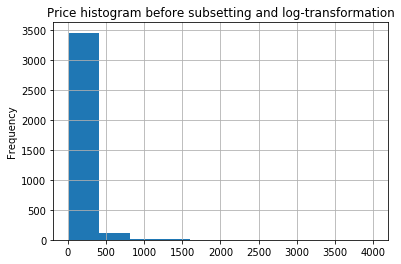

In [8]:
# Check the histgram of price
df["price"].plot(kind='hist', grid=True)
plt.title("Price histogram before subsetting and log-transformation");
plt.show()

In [9]:
df['price'].skew()

8.521483565683951

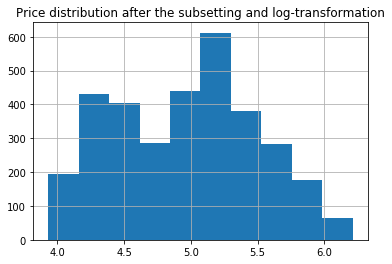

In [12]:
# Use a subset of the original data
df = df[(df["price"] > 50) & (df["price"] < 500)]
# Log transform and plot
target = np.log(df["price"])
target.hist()
plt.title("Price distribution after the subsetting and log-transformation")
plt.show()

In [14]:
feature_df = df.drop('price', axis=1)
print(feature_df.shape)
feature_df.head()

(3269, 16)


,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,minimum_nights,number_of_reviews,review_scores_value,instant_bookable
0,f,1,Roslindale,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,250.0,35.0,2,0,9.0,f
1,f,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,95.0,10.0,2,36,9.0,t
2,t,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,250.0,50.0,3,41,10.0,f
3,f,1,Roslindale,House,Private room,4,1.0,1.0,2.0,Real Bed,100.0,50.0,1,1,10.0,f
4,t,1,Roslindale,House,Private room,2,1.5,1.0,2.0,Real Bed,250.0,15.0,2,29,10.0,f


In [18]:
# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(feature_df, target, test_size=0.33, random_state=23)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2190, 16)
(1079, 16)
(2190,)
(1079,)


In [20]:
# Feature columns abstraction
numeric_columns = ['host_total_listings_count','accommodates','bathrooms','bedrooms','beds',
                   'security_deposit','cleaning_fee','minimum_nights','number_of_reviews',
                   'review_scores_value']
categorical_columns = ['host_is_superhost','neighbourhood_cleansed','property_type','room_type',
                       'bed_type','instant_bookable']

In [21]:
# Numerical features
numeric_features = [tf.feature_column.numeric_column(key=column) for column in numeric_columns]
print(numeric_features[0])

_NumericColumn(key='host_total_listings_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


In [23]:
# Categorical features
categorical_features = [
    tf.feature_column.categorical_column_with_vocabulary_list(key=column, vocabulary_list=feature_df[column].unique())
    for column in categorical_columns
]
print(categorical_features[1])

_VocabularyListCategoricalColumn(key='neighbourhood_cleansed', vocabulary_list=('Roslindale', 'Jamaica Plain', 'Mission Hill', 'Longwood Medical Area', 'Bay Village', 'Leather District', 'Chinatown', 'North End', 'Roxbury', 'South End', 'Back Bay', 'East Boston', 'Charlestown', 'West End', 'Beacon Hill', 'Downtown', 'Fenway', 'Brighton', 'West Roxbury', 'Hyde Park', 'Mattapan', 'Dorchester', 'South Boston Waterfront', 'South Boston', 'Allston'), dtype=tf.string, default_value=-1, num_oov_buckets=0)


In [24]:
linear_features = numeric_features + categorical_features

In [25]:
# Build input function

# Create training input function
training_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_train,
                                                        y=Y_train,
                                                        batch_size=32,
                                                        shuffle=True,
                                                        num_epochs=None)

# Create testing input function
eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,
                                                    y=Y_test,
                                                    batch_size=32,
                                                    shuffle=False,
                                                    num_epochs=1)

In [26]:
# Create the model
linear_regressor = tf.estimator.LinearRegressor(feature_columns=linear_features,
                                                model_dir="model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb16656ba8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [27]:
# Train the model
linear_regressor.train(input_fn=training_input_fn, steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.
INFO:tensorflow:loss = 873.00775, step = 1
INFO:tensorflow:global_step/sec: 172.022
INFO:tensorflow:loss = 35.867825, step = 101 (0.582 sec)
INFO:tensorflow:global_step/sec: 261.537
INFO:tensorflow:loss = 10.216842, step = 201 (0.382 sec)
INFO:tensorflow:global_step/sec: 291.564
INFO:tensorflow:loss = 7.9986954, step = 301 (0.346 sec)
INFO:tensorflow:global_step/sec: 321.87
INFO:tensorflow:loss = 6.3207474, step = 401 (0.309 sec)
INFO:tensorflow:global_step/sec: 382.059
INFO:tensorflow:loss = 3.7631874, step = 501 (0.262 sec)
INFO:tensorflow:global_step/sec: 393.857
INFO:tensorflow:loss = 5.146807, step = 601 (0.254 sec)
INFO:tensorflow:global_step/sec: 377.238
INFO:tensorflow:loss = 6.5861

In [28]:
# Evaluate the model
linear_regressor.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-15-15:23:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-15-15:23:21
INFO:tensorflow:Saving dict for global step 2000: average_loss = 0.30426726, global_step = 2000, loss = 9.656012
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: model/model.ckpt-2000


{'average_loss': 0.30426726, 'loss': 9.656012, 'global_step': 2000}

In [29]:
# Get the predictions
pred = list(linear_regressor.predict(input_fn=eval_input_fn))
pred[0]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'predictions': array([4.5840683], dtype=float32)}

In [30]:
pred = [p['predictions'][0] for p in pred]
pred[:10]

[4.5840683,
 4.57374,
 5.0369954,
 5.791486,
 4.259334,
 4.0976076,
 5.393248,
 4.715527,
 5.473164,
 4.933282]

In [31]:
prices = np.exp(pred)
print(prices)

[ 97.91192  96.90586 154.00659 ... 146.59955 191.9363  178.63893]


In [32]:
# Visualize feature weights
linear_regressor.get_variable_names()[5:10]

['linear/linear_model/bathrooms/weights/part_0/Ftrl',
 'linear/linear_model/bathrooms/weights/part_0/Ftrl_1',
 'linear/linear_model/bed_type/weights',
 'linear/linear_model/bed_type/weights/part_0/Ftrl',
 'linear/linear_model/bed_type/weights/part_0/Ftrl_1']

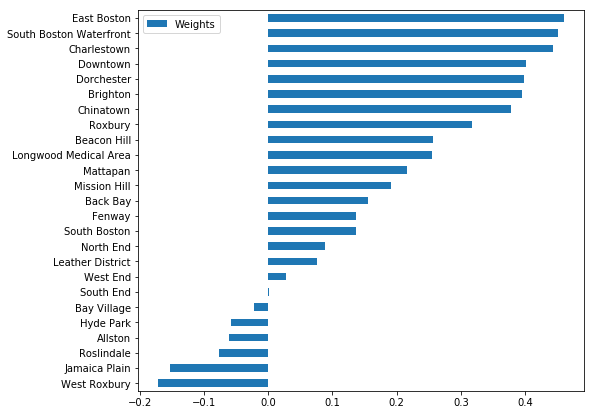

In [33]:
property_weights = linear_regressor.get_variable_value('linear/linear_model/neighbourhood_cleansed/weights').flatten()
property_keys = df["neighbourhood_cleansed"].value_counts().keys()
pd.DataFrame({"Weights": property_weights}, index=property_keys)\
             .sort_values("Weights", ascending=True)\
             .plot(kind="barh", figsize= (8, 7), grid=False)